In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from collections import Counter
from IPython.core.display import display, HTML

train=pd.read_csv('C:/Users/chaeh/train_features.csv')
train_labels=pd.read_csv('C:/Users/chaeh/train_labels.csv')
test=pd.read_csv('C:/Users/chaeh/test_features.csv')
submission=pd.read_csv('C:/Users/chaeh/sample_submission.csv')

In [37]:
train.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234


In [38]:
train_labels['label_desc']

0                Shoulder Press (dumbbell)
1                             Non-Exercise
2                       Biceps Curl (band)
3                             Non-Exercise
4                             Non-Exercise
                       ...                
3120                          Non-Exercise
3121                          Non-Exercise
3122    Dynamic Stretch (at your own pace)
3123                          Non-Exercise
3124                            Bicep Curl
Name: label_desc, Length: 3125, dtype: object

In [39]:
train_labels.columns

Index(['id', 'label', 'label_desc'], dtype='object')

In [40]:
train.columns

Index(['id', 'time', 'acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z'], dtype='object')

In [48]:
train_labels_merge=pd.merge(train,train_labels,on="id")
features = ['id', 'acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z']

In [49]:
train[features].groupby('id').max() #time중 가장 max인 것 ..

,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
id,,,,,,
0,1.344268,0.176871,-0.054876,31.644123,69.847244,55.953827
1,1.234020,0.700065,0.888661,286.624363,389.608060,340.170199
2,1.219836,0.650645,1.332992,73.525082,297.320834,55.642836
3,-0.622250,0.283721,0.598814,192.765368,159.083788,56.456908
4,0.599720,1.724782,2.678034,613.972600,284.952954,221.015193
...,...,...,...,...,...,...
3120,0.390798,0.168070,0.849966,148.152235,134.585268,121.958427
3121,-0.446650,0.117965,0.218621,155.958950,53.341929,57.349878
3122,0.744666,1.268138,0.803950,400.662632,388.749570,453.943910


In [50]:
X_train=train[features].groupby('id').mean() #time의 평균
X_train

,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
id,,,,,,
0,0.931329,-0.218471,-0.370422,-1.865269,-3.359506,1.182107
1,-0.766580,-0.317258,-0.004223,11.071600,1.740475,1.393294
2,0.039836,-0.082403,0.626012,-8.472951,0.597877,3.053291
3,-0.887702,-0.087668,0.227357,17.744167,4.800931,-5.869898
4,-0.659018,-0.337067,0.202758,-4.819638,9.651713,4.453382
...,...,...,...,...,...,...
3120,-0.300454,-0.669209,0.335934,-5.382982,-4.902798,-0.054026
3121,-0.974298,-0.233373,-0.073771,11.394976,3.786842,-2.792238
3122,-1.114246,-0.362196,0.241518,-3.821330,10.172169,-1.722830


In [51]:
X_test=test[features].groupby('id').mean()
X_test

,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
id,,,,,,
3125,-1.018731,-0.019574,-0.232259,-3.185128,2.731872,-2.000683
3126,-0.522843,0.612161,-0.071092,-17.741526,6.974772,-3.604579
3127,0.506947,0.903819,-0.141098,-2.179745,-2.251452,-0.393175
3128,-0.577603,-0.610557,0.031486,0.808579,-2.984969,-0.024318
3129,-0.738640,0.182535,0.401302,-1.431538,1.442366,5.745498
...,...,...,...,...,...,...
3902,-0.907299,0.488264,-0.238160,5.218293,1.218743,-0.429678
3903,-0.608731,0.371269,-0.106845,6.350148,3.987078,13.272141
3904,-0.753193,0.199782,0.311769,-0.761053,-2.325664,1.935083


In [52]:
def plot_acc_id(df, id_num):
    return df.query('id == @id_num')[['time', 'acc_x', 'acc_y', 'acc_z']].plot(x = 'time')

def plot_gy_id(df, id_num):
    return df.query('id == @id_num')[['time', 'gy_x', 'gy_y', 'gy_z']].plot(x = 'time')

<AxesSubplot:xlabel='time'>

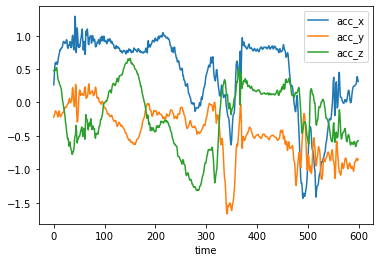

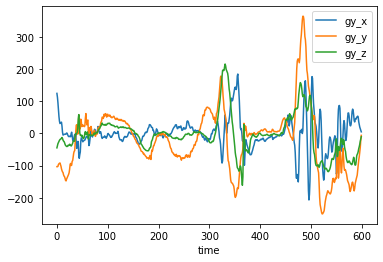

In [53]:
plot_acc_id(train, 122)
plot_gy_id(train,122)

In [54]:
X_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
acc_x,782.0,-0.450305,0.527296,-1.504693,-0.894179,-0.603330,-0.146107,1.016206
acc_y,782.0,-0.188638,0.430875,-1.062517,-0.485794,-0.245897,0.056554,1.050350
acc_z,782.0,0.047377,0.341953,-1.074045,-0.149664,0.030966,0.266612,1.005100
gy_x,782.0,-1.368040,10.552588,-50.624786,-5.253808,-1.239620,2.466666,115.723820
gy_y,782.0,-0.886681,7.810353,-54.919691,-3.946176,-0.968877,2.493274,77.761288
gy_z,782.0,0.524323,6.283368,-40.986026,-2.377328,0.202773,3.071314,37.234866


In [55]:
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
Y_train = train_labels['label'].values.reshape(-1,1)
print("Shape of y_train: ",Y_train.shape)

Shape of X_train:  (3125, 6)
Shape of X_test:  (782, 6)
Shape of y_train:  (3125, 1)


In [115]:
# Feature Scaling - feature들을 서로 정규화 시켜주는 작업
from sklearn.preprocessing import RobustScaler
sc = RobustScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [116]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier_lr = LogisticRegression(C=1, fit_intercept=True, max_iter=1000, penalty = 'l2', solver='liblinear') #첫번째 LR실행
classifier_lr.fit(X_train_scaled, Y_train.ravel()) #학습시킴

LogisticRegression(C=1, max_iter=1000, solver='liblinear')

In [117]:
cv_lr = cross_val_score(estimator = classifier_lr, X = X_train_scaled, y = Y_train.ravel(), cv = 10) #선형회귀로 10겹 교차검증
print("CV: ", cv_lr.mean())

Y_pred_lr_train = classifier_lr.predict(X_train_scaled) #x_train_scaled 를 활용하여 y값을 예측가게 함
accuracy_lr_train = accuracy_score(Y_train, Y_pred_lr_train) #train(원래)값과 예측 값의 정확도
print("Training set: ", accuracy_lr_train)

Y_pred_lr_test = classifier_lr.predict(X_test_scaled)
Y_pred_lr_test

CV:  0.5190392807405587
Training set:  0.52256


array([26, 26, 26, 26, 26, 26, 26, 26, 26, 37, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26,  2, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26,  6, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 26, 26, 26, 26,  8,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26,  8, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 27, 26, 26, 37, 26, 26, 26, 26, 26, 26, 26, 19, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 26, 26, 26,
       26, 26, 27, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 27, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26

In [118]:
from sklearn.neighbors import KNeighborsClassifier
classifier_knn = KNeighborsClassifier(leaf_size = 1, metric = 'minkowski', n_neighbors = 32, weights = 'distance') #가까울수록 큰 가중치, 32인접샘플수
classifier_knn.fit(X_train_scaled, Y_train.ravel())

KNeighborsClassifier(leaf_size=1, n_neighbors=32, weights='distance')

In [119]:
cv_knn = cross_val_score(estimator = classifier_knn, X = X_train_scaled, y= Y_train.ravel(), cv = 10)
print("CV: ", cv_knn.mean())

Y_pred_knn_train = classifier_knn.predict(X_train_scaled)
accuracy_knn_train = accuracy_score(Y_train, Y_pred_knn_train)
print("Training set: ", accuracy_knn_train)

y_pred_knn_test = classifier_knn.predict_proba(X_test_scaled)
y_pred_knn_test
#print(y_pred_knn_test.shape)

CV:  0.5820758581141969
Training set:  1.0


array([[0.        , 0.        , 0.        , ..., 0.02538873, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02478644, 0.05928301, 0.        , ..., 0.        , 0.05751842,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.05975024],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02949119, 0.        ,
        0.        ]])

In [120]:
#Support Vector Machine (SVM - Linear) 
# Fitting classifier to the Training set
from sklearn.svm import SVC
classifier_svm_linear = SVC(kernel = 'linear' ,probability=True) #선을 그어주는것
classifier_svm_linear.fit(X_train_scaled, Y_train.ravel())


SVC(kernel='linear', probability=True)

In [121]:
cv_svm_linear = cross_val_score(estimator = classifier_svm_linear, X = X_train_scaled, y = Y_train.ravel(), cv = 10)
print("CV: ", cv_svm_linear.mean())

Y_pred_svm_linear_train = classifier_svm_linear.predict(X_train_scaled)
accuracy_svm_linear_train = accuracy_score(Y_train, Y_pred_svm_linear_train)
print("Training set: ", accuracy_svm_linear_train)

Y_pred_svm_linear_test = classifier_svm_linear.predict_proba(X_test_scaled)
Y_pred_svm_linear_test

CV:  0.5699199229950029
Training set:  0.58208


array([[0.00397345, 0.00090547, 0.00100521, ..., 0.03663492, 0.00066375,
        0.01157198],
       [0.00151968, 0.0013793 , 0.00039178, ..., 0.0010773 , 0.00093396,
        0.00465662],
       [0.00656009, 0.04002045, 0.00162663, ..., 0.00118545, 0.05061689,
        0.00396746],
       ...,
       [0.0031133 , 0.00047441, 0.00180653, ..., 0.00108403, 0.00043755,
        0.02328027],
       [0.00522892, 0.01744276, 0.00149234, ..., 0.00106215, 0.03117913,
        0.00258479],
       [0.00159476, 0.000623  , 0.00390846, ..., 0.00586231, 0.00046111,
        0.00844679]])

In [124]:
from sklearn.svm import SVC
classifier_svm_kernel = SVC(kernel = 'rbf', C = 10, tol = 0.001, gamma = 'scale',probability=True) #비선형으로 나눔
#C를 작게 하면 훈련 데이터의 분류를 부정확하게 하는 대신 (= decision boundary를 곧게 그리는 대신) Margin을 크게 합니다. 
#C를 크게 하면 Margin을 작게 하는 대신 훈련 데이터의 분류를 정확하게 (= decision boundray를 굴곡있게) 합니다.
classifier_svm_kernel.fit(X_train_scaled, Y_train.ravel())

SVC(C=10, probability=True)

In [126]:
# Predicting Cross Validation Score
cv_svm_kernel = cross_val_score(estimator = classifier_svm_kernel, X = X_train_scaled, y = Y_train.ravel(), cv = 10)
print("CV: ", cv_svm_kernel.mean())

Y_pred_svm_kernel_train = classifier_svm_kernel.predict(X_train_scaled)
accuracy_svm_kernel_train = accuracy_score(Y_train, Y_pred_svm_kernel_train)
print("Training set: ", accuracy_svm_kernel_train)

Y_pred_svm_kernel_test = classifier_svm_kernel.predict_proba(X_test_scaled)
Y_pred_svm_kernel_test
submission.iloc[:,1:]=Y_pred_svm_kernel_test
submission.to_csv('baseline_rf.csv', index=False)

CV:  0.6041594986483165
Training set:  0.6896


In [127]:
#Naive Bayes  베이즈 정리에 기반한 통계적 분류 기법
# Fitting classifier to the Training set
from sklearn.naive_bayes import GaussianNB
classifier_nb = GaussianNB()
classifier_nb.fit(X_train_scaled, Y_train.ravel())

GaussianNB()

In [129]:
# Predicting Cross Validation Score
cv_nb = cross_val_score(estimator = classifier_nb, X = X_train_scaled, y = Y_train.ravel(), cv = 10)
print("CV: ", cv_nb.mean())

Y_pred_nb_train = classifier_nb.predict(X_train_scaled)
accuracy_nb_train = accuracy_score(Y_train, Y_pred_nb_train)
print("Training set: ", accuracy_nb_train)

Y_pred_nb_test = classifier_nb.predict_proba(X_test_scaled)
Y_pred_nb_test

CV:  0.551661956254608
Training set:  0.57952


array([[4.45493054e-05, 9.87430596e-17, 1.99353093e-12, ...,
        3.06809245e-02, 1.69432084e-18, 7.78078661e-04],
       [6.81862448e-05, 4.85550656e-16, 2.72350641e-23, ...,
        4.02818711e-83, 8.74354159e-10, 1.62079447e-05],
       [2.94691658e-03, 3.18793745e-01, 7.21585594e-19, ...,
        0.00000000e+00, 2.15093473e-02, 7.17662478e-04],
       ...,
       [2.30691806e-03, 2.21644930e-09, 2.12752430e-05, ...,
        5.48933483e-25, 1.55756972e-12, 2.36005330e-01],
       [7.49311406e-05, 8.63455809e-04, 2.22278578e-17, ...,
        0.00000000e+00, 3.14194196e-04, 1.47660546e-06],
       [5.41478514e-05, 4.10876915e-14, 8.94836808e-08, ...,
        2.60481599e-20, 8.91898131e-13, 2.11506391e-05]])

In [113]:
from sklearn.tree import DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier(criterion = 'gini', max_features=6, max_leaf_nodes=400, random_state = 33) #지니계수 , 엔트로피계수
classifier_dt.fit(X_train_scaled, Y_train.ravel())

DecisionTreeClassifier(max_features=6, max_leaf_nodes=400, random_state=33)

In [114]:
cv_dt = cross_val_score(estimator = classifier_dt, X = X_train_scaled, y = Y_train.ravel(), cv = 10)
print("CV: ", cv_dt.mean())

Y_pred_dt_train = classifier_dt.predict(X_train_scaled)
accuracy_dt_train = accuracy_score(Y_train, Y_pred_dt_train)
print("Training set: ", accuracy_dt_train)

Y_pred_dt_test = classifier_dt.predict_proba(X_test_scaled)
Y_pred_dt_test 

CV:  0.4867238060129434
Training set:  0.76224


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00251889, 0.        , 0.00755668, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00251889, 0.        , 0.00755668, ..., 0.        , 0.        ,
        0.        ]])

In [72]:
models = [('Logistic Regression',  accuracy_lr_train,  cv_lr.mean()),
          ('K-Nearest Neighbors (KNN)', accuracy_knn_train,  cv_knn.mean()),
          ('SVM (Linear)',  accuracy_svm_linear_train,  cv_svm_linear.mean()),
          ('SVM (Kernel)', accuracy_svm_kernel_train,cv_svm_kernel.mean()),
          ('Naive Bayes',  accuracy_nb_train,  cv_nb.mean()),
          ('Decision Tree Classification',  accuracy_dt_train,  cv_dt.mean()),
          #('Random Forest Tree Classification',  accuracy_rf_train,  cv_rf.mean())
         ]

In [73]:
predict = pd.DataFrame(data = models, columns=['Model',  'Accuracy(training)',
                                               'Cross-Validation'])
predict


,Model,Accuracy(training),Cross-Validation
0,Logistic Regression,0.52416,0.519680
1,K-Nearest Neighbors (KNN),1.00000,0.587520
2,SVM (Linear),0.58016,0.567361
3,SVM (Kernel),0.70528,0.603206
4,Naive Bayes,0.57952,0.551662
5,Decision Tree Classification,0.79168,0.520652


In [27]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [74]:
train_labels_merge=pd.merge(train,train_labels,on="id")
features = ['id', 'acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z']
X_train = train[features].groupby('id').mean()
Y_train = train_labels['label']
X_test = test[features].groupby('id').mean()
X_train.shape,Y_train.shape, X_test.shape

((3125, 6), (3125,), (782, 6))

In [75]:
model = RandomForestClassifier(n_jobs=-1, random_state=0, min_samples_leaf=30)

In [76]:
model.fit(X_train, Y_train)

RandomForestClassifier(min_samples_leaf=30, n_jobs=-1, random_state=0)

In [77]:
y_pred = model.predict_proba(X_test)
y_pred

array([[0.00325281, 0.00020833, 0.00011905, ..., 0.03735216, 0.        ,
        0.02883991],
       [0.0045866 , 0.0012181 , 0.0036852 , ..., 0.00499022, 0.00077059,
        0.00434322],
       [0.00558127, 0.06128787, 0.00387055, ..., 0.        , 0.05451969,
        0.00347983],
       ...,
       [0.00154403, 0.00018519, 0.00769902, ..., 0.00088035, 0.00018519,
        0.04462214],
       [0.00216841, 0.00393621, 0.00098039, ..., 0.00025974, 0.00516733,
        0.00256929],
       [0.00096171, 0.00012987, 0.0066162 , ..., 0.00303842, 0.00143598,
        0.00716553]])

In [78]:
submission.iloc[:,1:] = y_pred
submission

,id,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,3125,0.003253,0.000208,0.000119,0.001823,0.058705,0.000000,0.001871,0.000524,0.002727,...,0.038297,0.028501,0.005713,0.001231,0.000345,0.000866,0.006993,0.037352,0.000000,0.028840
1,3126,0.004587,0.001218,0.003685,0.006163,0.008220,0.007083,0.000000,0.001731,0.003273,...,0.006310,0.000000,0.000769,0.000417,0.005680,0.003558,0.008216,0.004990,0.000771,0.004343
2,3127,0.005581,0.061288,0.003871,0.009347,0.000000,0.009914,0.013605,0.026021,0.126249,...,0.000345,0.000000,0.000000,0.040577,0.010545,0.079453,0.000247,0.000000,0.054520,0.003480
3,3128,0.000442,0.000510,0.021109,0.002770,0.006732,0.001203,0.000556,0.004880,0.032505,...,0.003432,0.000873,0.001512,0.001761,0.008811,0.000000,0.003039,0.000794,0.000185,0.037945
4,3129,0.000585,0.000480,0.005640,0.009750,0.000809,0.005883,0.000000,0.000863,0.012134,...,0.001302,0.000000,0.008923,0.000000,0.008246,0.002920,0.007358,0.000000,0.000635,0.006953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.008883,0.000000,0.000282,0.003185,0.015084,0.007168,0.000250,0.017452,0.008353,...,0.012612,0.004115,0.003101,0.002190,0.000916,0.005706,0.001994,0.001463,0.000000,0.013133
778,3903,0.003012,0.000000,0.000000,0.003039,0.002615,0.014184,0.000000,0.001519,0.000498,...,0.002271,0.000000,0.003681,0.000000,0.002888,0.005113,0.002463,0.000000,0.000000,0.001314
779,3904,0.001544,0.000185,0.007699,0.007789,0.007439,0.004148,0.001208,0.002626,0.053422,...,0.011121,0.003436,0.013468,0.000000,0.010312,0.000000,0.002380,0.000880,0.000185,0.044622
780,3905,0.002168,0.003936,0.000980,0.001488,0.001055,0.002019,0.186496,0.008587,0.018582,...,0.001109,0.000473,0.001259,0.011485,0.006216,0.014987,0.000377,0.000260,0.005167,0.002569


In [79]:
submission.to_csv('baseline_rf.csv', index=False)